In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# read data
whas100_df = pd.read_excel(io='whas100.xlsx', sheet_name='data', index_col=0)

whas100_df['Admission Date'] = pd.to_datetime(whas100_df['Admission Date'], format='%m/%d/%Y')
whas100_df['Follow Up Date'] = pd.to_datetime(whas100_df['Follow Up Date'], format='%m/%d/%Y')

whas100_df.loc[whas100_df['Vital Satus'] == 1, 'Vital Satus'] =  'Dead'
whas100_df.loc[whas100_df['Vital Satus'] == 0, 'Vital Satus'] =  'Alive'

whas100_df.loc[whas100_df['Gender'] == 1, 'Gender'] =  'Female'
whas100_df.loc[whas100_df['Gender'] == 0, 'Gender'] =  'Male'

whas100_df.head(10)

,Admission Date,Follow Up Date,Length of Hospital Stay,Follow Up Time,Vital Satus,Age at Admission,Gender,Body Mass Index
ID Code,,,,,,,,
1,1995-03-13,1995-03-19,4,6,Dead,65,Male,31.38134
2,1995-01-14,1996-01-23,5,374,Dead,88,Female,22.65790
3,1995-02-17,2001-10-04,5,2421,Dead,77,Male,27.87892
4,1995-04-07,1995-07-14,9,98,Dead,81,Female,21.47878
5,1995-02-09,1998-05-29,4,1205,Dead,78,Male,30.70601
6,1995-01-16,2000-09-11,7,2065,Dead,82,Female,26.45294
7,1995-01-17,1997-10-15,3,1002,Dead,66,Female,35.71147
8,1994-11-15,2000-11-24,56,2201,Dead,81,Female,28.27676
9,1995-08-18,1996-02-23,5,189,Dead,76,Male,27.12082


,time_start[day],time_end[day],time_start[year],time_end[year],number_at_risk,number_of_dead,number_of_onsoring,probability_at_t,survival_probability
0,0,6,0,0.0164271,100,0,0,1,1
1,6,14,0.0164271,0.0383299,100,2,0,0.98,0.98
2,14,44,0.0383299,0.120465,98,1,0,0.989796,0.97
3,44,62,0.120465,0.169747,97,1,0,0.989691,0.96
4,62,89,0.169747,0.243669,96,1,0,0.989583,0.95


,time_start[day],time_end[day],time_start[year],time_end[year],number_at_risk,number_of_dead,number_of_onsoring,probability_at_t,survival_probability
91,2631,2638,7.20329,7.22245,5,0,1,1,0.360561
92,2638,2641,7.22245,7.23066,4,0,1,1,0.360561
93,2641,2710,7.23066,7.41958,3,0,1,1,0.360561
94,2710,2719,7.41958,7.44422,2,1,0,0.5,0.180281
95,2719,inf,7.44422,inf,1,0,1,1,0.180281


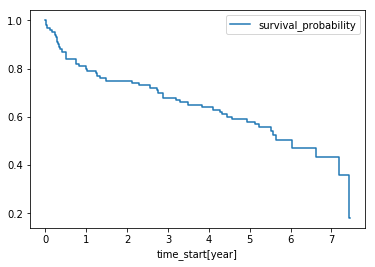

In [22]:
# Kaplan-Meier推定量の算出とグラフ化
n_tester = len(whas100_df)
status_key = 'Vital Satus'
time_key = 'Follow Up Time'
time_start_key = 'time_start[day]'
time_end_key = 'time_end[day]'

# time_year_key = 'survival_time[year]'
time_start_year_key = 'time_start[year]'
time_end_year_key = 'time_end[year]'

n_dead_key = 'number_of_dead'
n_consoring_key = 'number_of_onsoring'
n_risk_key = 'number_at_risk'
prob_t_key = 'probability_at_t'
prob_key = 'survival_probability'

# ---------- 解析用のデータフレーム作成準備 ----------
df_before_summrize = whas100_df.sort_values(by=time_key)
df_before_summrize = df_before_summrize[[status_key, time_key]]

df_before_summrize[n_dead_key] = 0
df_before_summrize.loc[df_before_summrize[status_key]=='Dead', n_dead_key] = 1

df_before_summrize[n_consoring_key] = 0
df_before_summrize.loc[df_before_summrize[status_key]=='Alive', n_consoring_key] = 1

unique_times = np.sort(df_before_summrize[time_key].unique())
unique_times = np.insert(unique_times, 0, 0)


# ---------- 解析用のデータフレーム作成 ----------
keys = [time_start_key, time_end_key, time_start_year_key, time_end_year_key,
        n_risk_key, n_dead_key, n_consoring_key, prob_t_key, prob_key]
analysis_df = pd.DataFrame(columns=keys)
for i,t in enumerate(unique_times):
    analysis_df.loc[i, time_start_key] = unique_times[i]
    if i == len(unique_times)-1:
        analysis_df.loc[i, time_end_key] = np.inf
    else:
        analysis_df.loc[i, time_end_key] = unique_times[i+1]
    
    if i == 0:
        analysis_df.loc[i, n_dead_key] = 0
        analysis_df.loc[i, n_consoring_key] = 0
        analysis_df.loc[i, n_risk_key] = n_tester
        analysis_df.loc[i, prob_t_key] = 1
        analysis_df.loc[i, prob_key] = 1
    else:
        df_i = df_before_summrize[df_before_summrize[time_key] == t]
        n_dead_i = df_i[n_dead_key].sum()
        n_consoring_i = df_i[n_consoring_key].sum()
        n_risk_i = analysis_df.loc[i-1, n_risk_key]
        n_risk_i = n_risk_i - analysis_df.loc[i-1, n_dead_key] - analysis_df.loc[i-1, n_consoring_key]
        prob_t_i = (n_risk_i - n_dead_i) / n_risk_i
        prob_i = analysis_df.loc[i-1, prob_key] * prob_t_i

        # 死亡数、打ち切り数、リスク数、生存確率を代入
        analysis_df.loc[i, n_dead_key] = n_dead_i
        analysis_df.loc[i, n_consoring_key] = n_consoring_i
        analysis_df.loc[i, n_risk_key] = n_risk_i
        analysis_df.loc[i, prob_t_key] = prob_t_i
        analysis_df.loc[i, prob_key] = prob_i

analysis_df[time_start_year_key] = analysis_df[time_start_key] / 365.25
analysis_df[time_end_year_key] = analysis_df[time_end_key] / 365.25
display(analysis_df.head(5))
display(analysis_df.tail(5))

# ---------- 生存確率のグラフ ----------
analysis_df.plot(x=time_start_year_key, y=prob_key, drawstyle='steps-post')
plt.show()

,time_start[year],time_end[year],number_at_risk,number_of_dead,number_of_onsoring,probability_at_t,survival_probability
0,0.0,1.0,100.0,0.0,0.0,1.000000,1.00
1,1.0,2.0,100.0,20.0,0.0,0.800000,0.80
2,2.0,3.0,80.0,5.0,0.0,0.937500,0.75
3,3.0,4.0,75.0,7.0,0.0,0.906667,0.68
4,4.0,5.0,68.0,4.0,0.0,0.941176,0.64


,time_start[year],time_end[year],number_at_risk,number_of_dead,number_of_onsoring,probability_at_t,survival_probability
4,4.0,5.000000,68.0,4.0,0.0,0.941176,0.640000
5,5.0,6.000000,64.0,6.0,0.0,0.906250,0.580000
6,6.0,7.000000,58.0,5.0,39.0,0.870130,0.504675
7,7.0,8.000000,14.0,2.0,0.0,0.857143,0.432579
8,8.0,inf,12.0,2.0,10.0,0.714286,0.308985


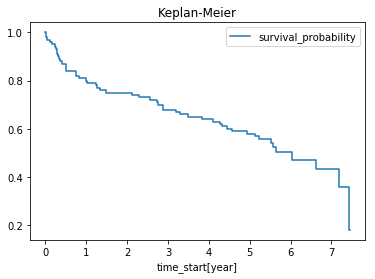

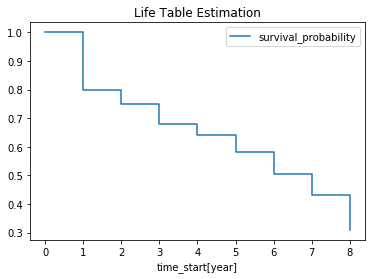

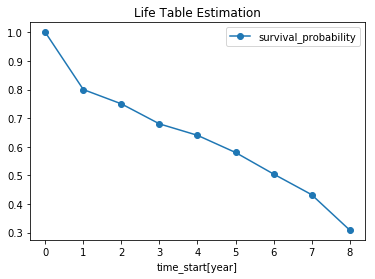

In [49]:
# 生存関数の生命表推定値の算出
# 生命表の作成
life_table = pd.DataFrame()
time_max = analysis_df[time_start_year_key].max()
start_times = np.arange(0, time_max+1, 1)    

for i in range(len(start_times)):
    # 開始時間と終了時間を算出
    life_table.loc[i, time_start_year_key] = start_times[i]
    if i == len(start_times)-1:
        life_table.loc[i, time_end_year_key] = np.inf
    else:
        life_table.loc[i, time_end_year_key] = start_times[i+1]
    
    # リスク数、死亡数、打ち切り数、生存確率を算出
    if i == 0:
        n_risk_i = analysis_df.loc[0, n_risk_key]
        n_dead_i = 0
        n_consoring_i = 0
        prob_t_i = 1
        prob_i = 1
    else:
        mask_i = life_table.loc[i-1, time_start_year_key] <= analysis_df[time_start_year_key]
        mask_i = mask_i & (analysis_df[time_start_year_key] < life_table.loc[i-1, time_end_year_key])
        df_i = analysis_df[mask_i]
        
        if len(df_i) == 0:
            n_dead_i = 0
            n_consoring_i = 0
        else:
            n_dead_i = df_i[n_dead_key].sum()
            n_consoring_i = df_i[n_consoring_key].sum()
        
        n_risk_i = life_table.loc[i-1, n_risk_key] - life_table.loc[i-1, n_dead_key] - life_table.loc[i-1, n_consoring_key]
        prob_t_i = (n_risk_i - n_consoring_i/2 - n_dead_i) / (n_risk_i - n_consoring_i/2)
        prob_i = life_table.loc[i-1, prob_key] * prob_t_i
        
    # 算出結果を代入
    life_table.loc[i, n_risk_key] = n_risk_i
    life_table.loc[i, n_dead_key] = n_dead_i
    life_table.loc[i, n_consoring_key] = n_consoring_i
    life_table.loc[i, prob_t_key] = prob_t_i
    life_table.loc[i, prob_key] = prob_i

display(life_table.head(5))
display(life_table.tail(5))

# ---------- 生命表推定値のグラフ ----------
analysis_df.plot(x=time_start_year_key, y=prob_key, drawstyle='steps-post', title='Keplan-Meier')
life_table.plot(x=time_start_year_key, y=prob_key, drawstyle='steps-post', title='Life Table Estimation')
life_table.plot(x=time_start_year_key, y=prob_key, marker='o', title='Life Table Estimation')
plt.show()